# Introduzione
Questo processo descrive la creazione di una pipeline per la classificazione automatica degli articoli di Wikipedia, utilizzando tecniche di preprocessing del testo e modelli di machine learning. L'obiettivo principale è suddividere i contenuti di Wikipedia in categorie predefinite.

1. **Scaricamento del Dataset:** 
Utilizzo di wget per scaricare il dataset CSV da un link S3.

In [0]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, length
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report
import os
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, LinearSVC, GBTClassifier, NaiveBayes
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql import SparkSession
import pandas as pd
from pyspark.sql.functions import concat_ws

# Inizializzazione di Spark
spark = SparkSession.builder.appName("WikipediaAnalysis").getOrCreate()

# Caricamento del dataset
os.system('wget -O /tmp/wikipedia.csv https://proai-datasets.s3.eu-west-3.amazonaws.com/wikipedia.csv')
dataset = pd.read_csv('/tmp/wikipedia.csv')
spark_df = spark.createDataFrame(dataset)



In [0]:
spark_df = spark_df.drop("Unnamed: 0")

# Creazione della colonna 'combined_text' combinando il sommario e il testo completo
spark_df = spark_df.withColumn("combined_text", concat_ws(" ", spark_df["summary"], spark_df["documents"]))
spark_df = spark_df.drop("documents")
spark_df = spark_df.drop("summary")

In [0]:


for cat in spark_df.select("categoria").distinct().collect():
    # Verifica dei primi dati combinati
    print(f"Primi dati per la categoria: {cat[0]}")
    display(spark_df.filter(spark_df.categoria == cat[0]).select("combined_text").limit(3))




2. **Data Exploration:**

* Numero di articoli per categoria: Controllo della distribuzione degli articoli nelle diverse categorie. Questo aiuta a capire se alcune categorie sono sbilanciate.
* Lunghezza media degli articoli: Calcolo della lunghezza media degli articoli, considerando sia i sommari che il testo completo, per comprendere la variabilità dei contenuti.
* Lunghezza degli articoli: Identificazione degli articoli più lunghi e più corti in ciascuna categoria.
* Pulizia del dataset: Eliminazione di eventuali documenti vuoti o duplicati.
* Wordcloud: Creazione di nuvole di parole per ogni categoria per visualizzare i termini più frequenti e rilevanti nel dataset. Questo fornisce un'idea visiva delle parole chiave per ogni categoria tematica.

In [0]:
# Analisi esplorativa dei dati
import matplotlib.pyplot as plt
import seaborn as sns

# Esploriamo i dati per identificare le categorie
spark_df.groupBy("categoria").count().show()

# Calcolare la lunghezza media degli articoli per categoria
spark_df.createOrReplaceTempView("wikipedia")
length_query = """
SELECT categoria, AVG(LENGTH(combined_text)) as avg_length, MIN(LENGTH(combined_text)) as min_length, MAX(LENGTH(combined_text)) as max_length
FROM wikipedia
GROUP BY categoria
ORDER BY avg_length DESC
"""
avg_lengths = spark.sql(length_query).toPandas()


print("Lunghezza degli articoli per categoria:")
display(avg_lengths)






+-----------+-----+
|  categoria|count|
+-----------+-----+
|  economics|10110|
|   politics|11358|
|    culture|10372|
|    science|10236|
|     sports|10068|
|     energy|10046|
|    finance|10157|
| humanities|10236|
|       pets|10023|
|      trade|10068|
| technology|10095|
|  transport|10130|
|   medicine|10076|
|engineering|10220|
|   research|10037|
+-----------+-----+

Lunghezza degli articoli per categoria:


categoria avg_length min_length max_length science 12391.10658460336 0 177274 finance 12088.992419021364 0 190311 politics 10713.456858601867 114 128611 humanities 7086.498729972645 0 135889 economics 7054.898615232443 119 154032 technology 6236.122932144626 0 116874 medicine 5708.5471417229055 0 122467 research 5189.725714855036 0 159508 engineering 5084.413502935421 0 79882 culture 4613.463266486695 0 106103 trade 4597.744139849026 0 127273 transport 4411.361895360316 0 137456 energy 4303.50109496317 0 149799 sports 4100.495431068733 0 118992 pets 3020.369350493864 0 82513

In [0]:
from pyspark.sql import functions as F
from pyspark.sql.functions import length, col

# Crea una nuova colonna 'is_empty' che indica se l'articolo è vuoto
spark_df = spark_df.withColumn("is_empty",  (length(col("combined_text")) == 0))

# Filtra gli articoli vuoti
empty_articles = spark_df.filter(col("is_empty") == True)

# Conta il numero di articoli vuoti per categoria
empty_articles_count = empty_articles.groupBy("categoria").count()

# Mostra i risultati
empty_articles_count.show()

+-----------+-----+
|  categoria|count|
+-----------+-----+
|    culture|  217|
|    science|   70|
|     sports|    2|
|     energy|   13|
|    finance|  294|
| humanities|  120|
|       pets|    7|
|      trade|    4|
| technology|   13|
|  transport|   19|
|   medicine|   61|
|   research|  107|
|engineering|    1|
+-----------+-----+



In [0]:


from pyspark.sql import functions as F  

# Conta i duplicati per ogni categoria
duplicate_counts = (
    spark_df.groupBy("categoria", "combined_text")
    .count()
    .filter(F.col("count") > 1)
    .groupBy("categoria")
    .agg(F.count("*").alias("num_duplicati"))
)

# Mostra i risultati
duplicate_counts.show(truncate=False)

+-----------+-------------+
|categoria  |num_duplicati|
+-----------+-------------+
|finance    |2323         |
|medicine   |1172         |
|research   |1688         |
|technology |2121         |
|energy     |2258         |
|transport  |1597         |
|politics   |46           |
|culture    |1199         |
|science    |1100         |
|humanities |2704         |
|economics  |1648         |
|trade      |1311         |
|sports     |2394         |
|pets       |3221         |
|engineering|2312         |
+-----------+-------------+



+-----------+-----+
|  categoria|count|
+-----------+-----+
|    finance| 5328|
|   medicine| 8281|
|   research| 7571|
| technology| 6669|
|     energy| 4552|
|  transport| 7904|
|   politics|  243|
|    culture| 2151|
|    science| 3648|
| humanities| 5794|
|  economics| 4259|
|      trade| 3853|
|     sports| 3624|
|       pets| 4610|
|engineering| 6087|
+-----------+-----+

Lunghezza degli articoli per categoria:


categoria avg_length min_length max_length politics 14266.218106995884 114 128611 finance 8943.261073573574 15 190311 science 7842.4276315789475 147 177274 trade 6577.289644432909 185 127273 economics 6546.973937544024 119 154032 humanities 6403.951501553331 113 135889 technology 6072.827260458839 59 116874 culture 5991.257554625756 125 106103 medicine 5650.533389687236 137 122467 engineering 5284.530967635946 101 79882 research 5197.065513142254 217 159508 sports 5064.330573951435 130 118992 energy 4494.461555360282 121 149799 transport 3338.0673076923076 76 137456 pets 2951.2639913232106 127 82513

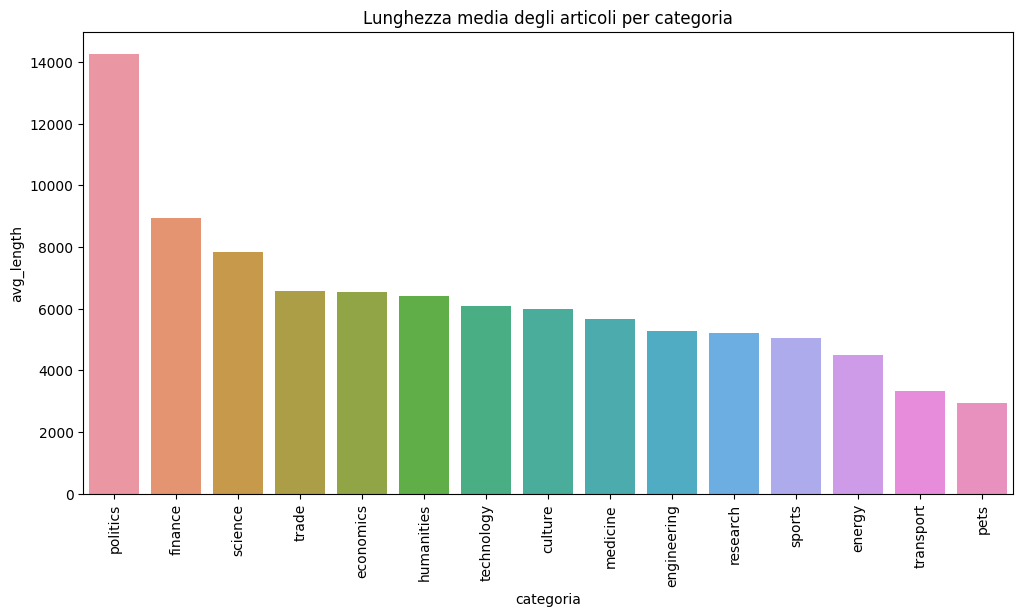

In [0]:
# Rimuovere gli articoli con testo vuoto (lunghezza zero)
spark_df_cleaned = spark_df.filter(col("is_empty") == False)

# 3. Rimuovi i duplicati mantenendo solo una occorrenza di ciascun 'combined_text' per categoria
spark_df_cleaned = spark_df_cleaned.dropDuplicates(["categoria", "combined_text"])

spark_df_cleaned.groupBy("categoria").count().show()



spark_df_cleaned.createOrReplaceTempView("wikipedia")
avg_lengths = spark.sql(length_query).toPandas()


print("Lunghezza degli articoli per categoria:")
display(avg_lengths)



# Visualizzare i risultati in un grafico
plt.figure(figsize=(12, 6))
sns.barplot(data=avg_lengths, x="categoria", y="avg_length")
plt.xticks(rotation=90)
plt.title("Lunghezza media degli articoli per categoria")
plt.show()




In [0]:
spark_df_cleaned.write.mode("overwrite").saveAsTable("wikipedia_table")


In [0]:
%pip install wordcloud

from wordcloud import WordCloud

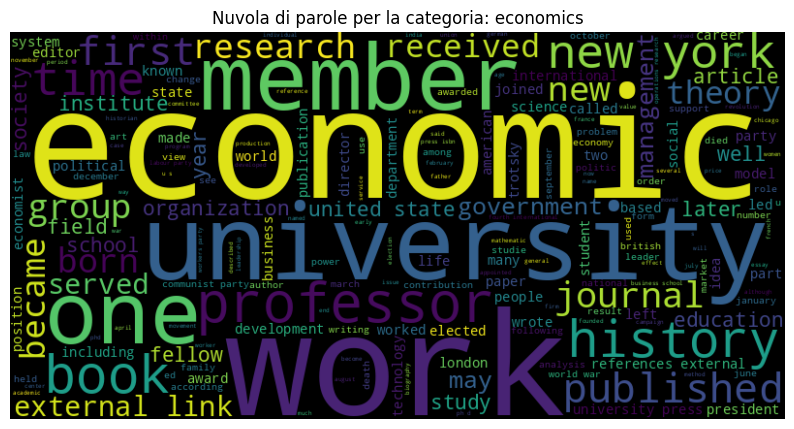

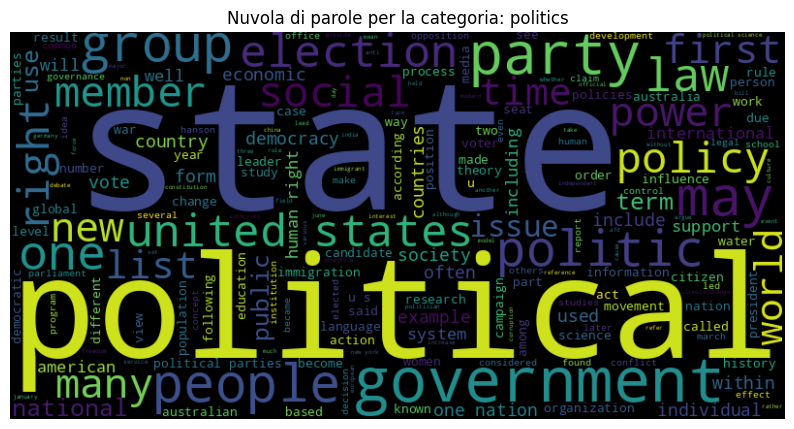

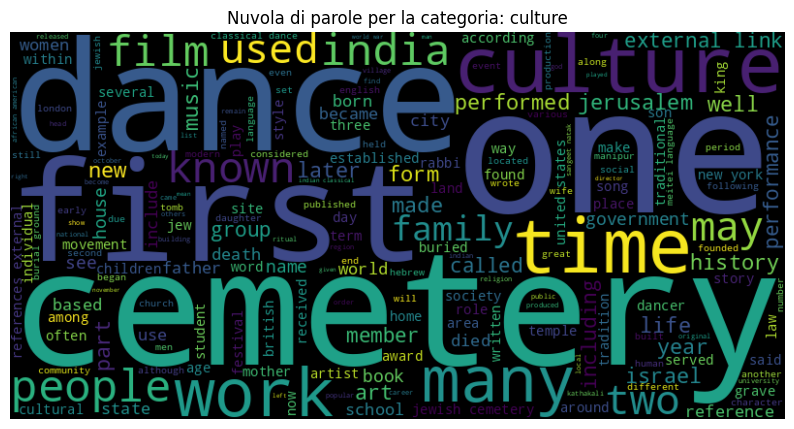

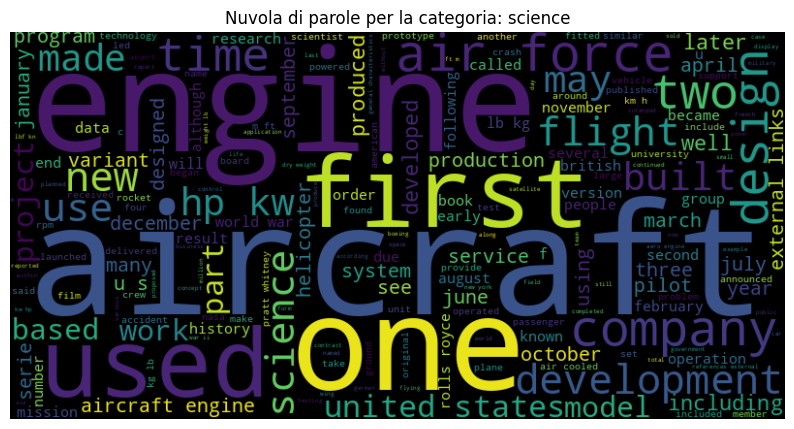

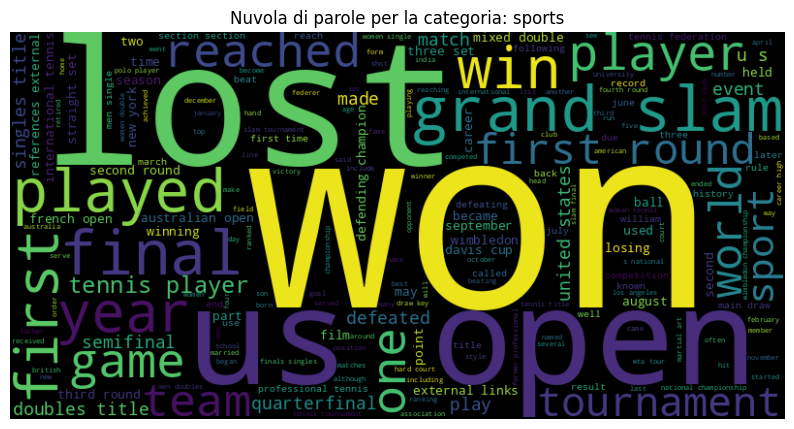

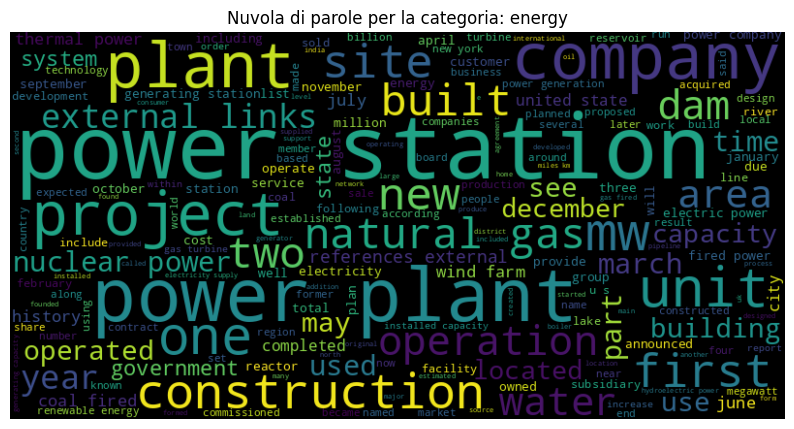

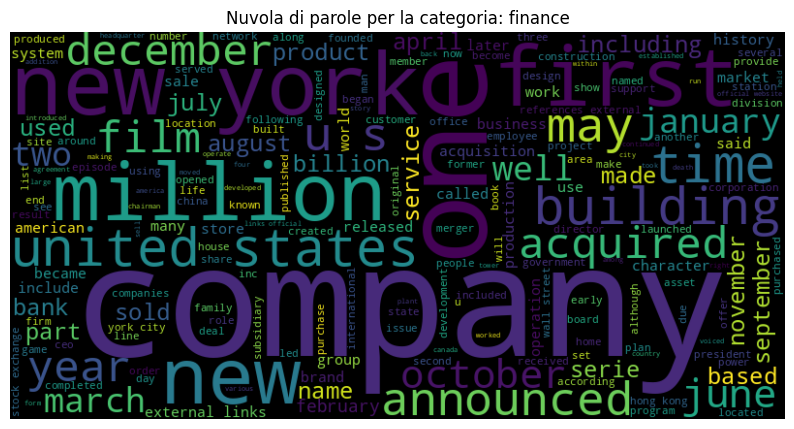

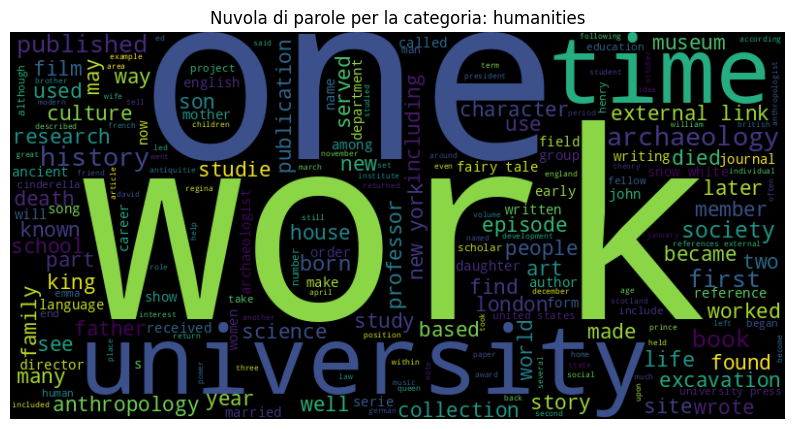

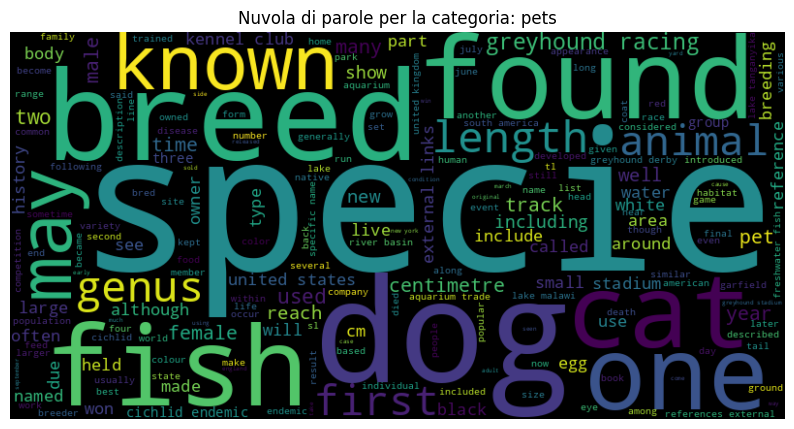

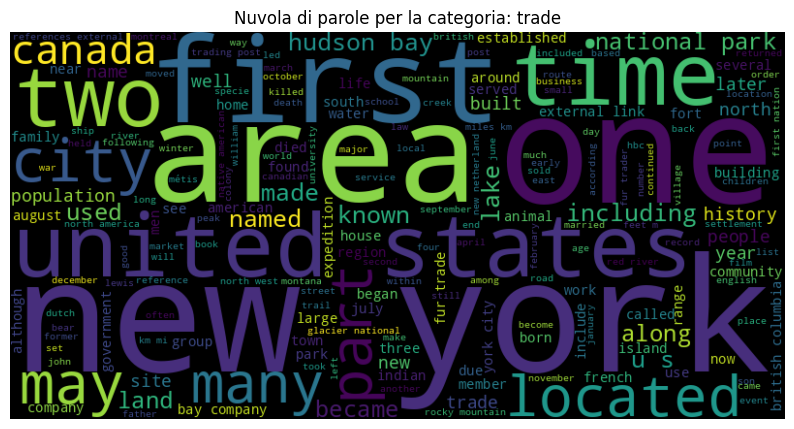

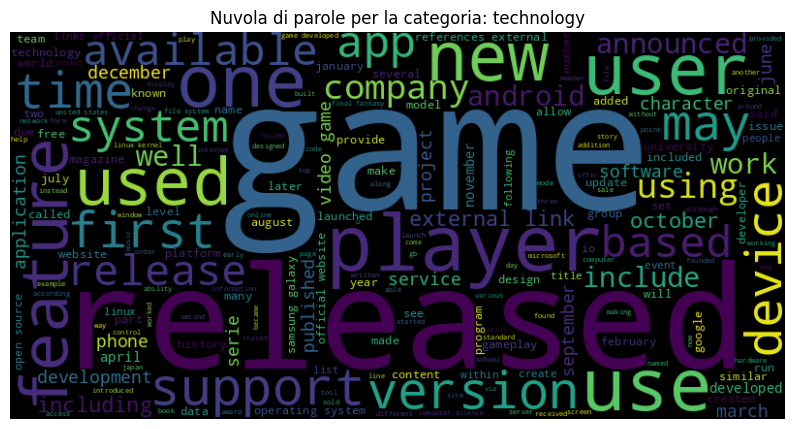

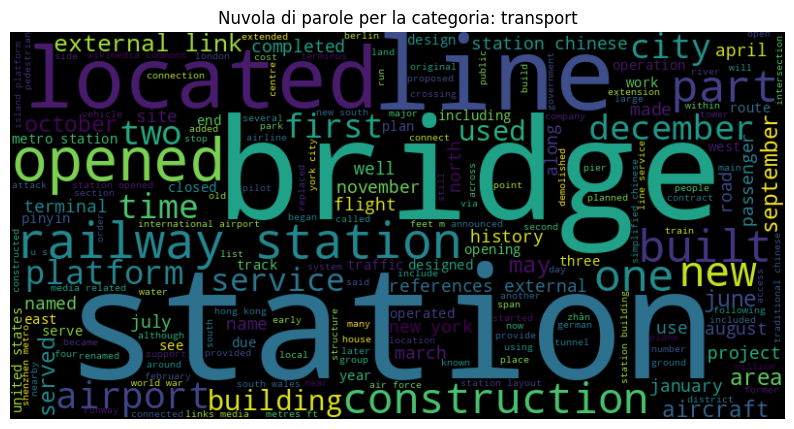

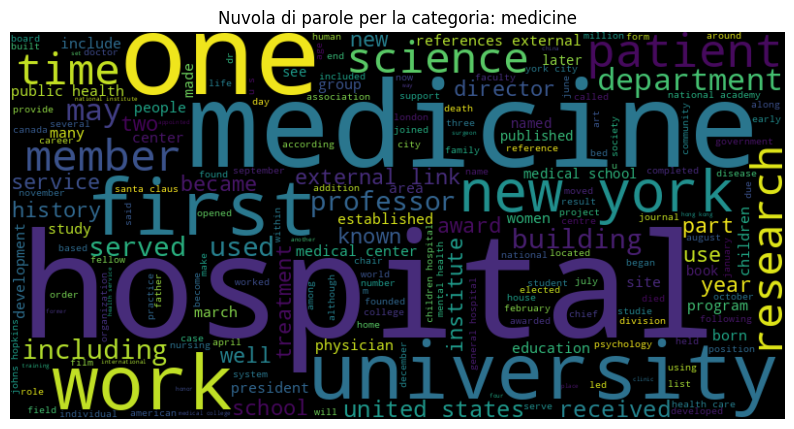

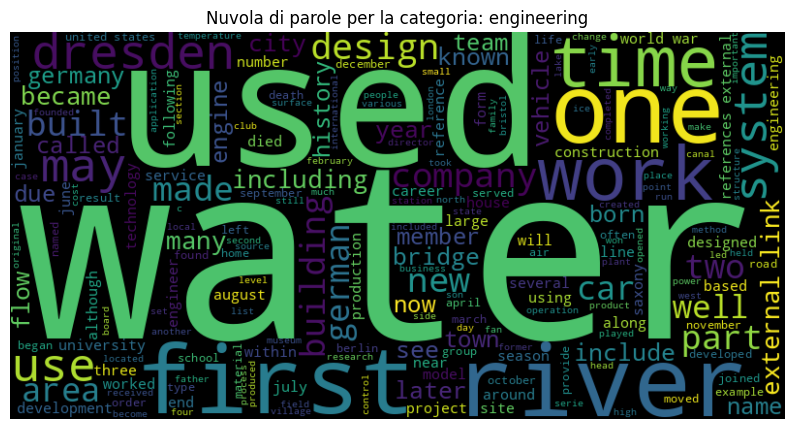

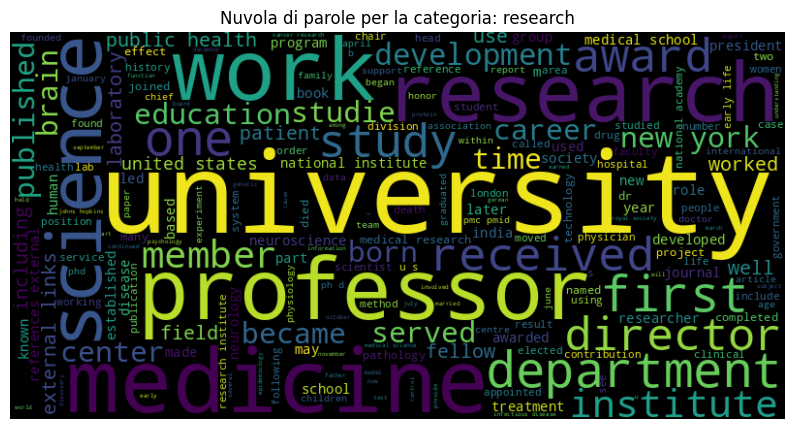

In [0]:
# Funzione per generare la nuvola di parole per una categoria
def generate_wordcloud(category):
    category_df = spark_df_cleaned.filter(spark_df_cleaned.categoria == category).select("combined_text")
    text = " ".join([row['combined_text'] for row in category_df.collect()])
    wordcloud = WordCloud(width=800, height=400).generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Nuvola di parole per la categoria: {category}")
    plt.show()

for category in spark_df_cleaned.select("categoria").distinct().collect():
    generate_wordcloud(category[0])

3. **Pre-processing:**

* **Tokenizzazione:** Utilizzo di Tokenizer per suddividere il testo in parole (tokens).
* **Rimozione delle stopwords:** Utilizzo di StopWordsRemover per eliminare le parole comuni non rilevanti.
* **Creazione delle features:** Utilizzo di HashingTF per ottenere una rappresentazione numerica iniziale del testo e applicazione di IDF per calcolare l'importanza di ogni parola nel dataset.
* **Labelling delle categorie:** Utilizzo di StringIndexer per convertire le etichette testuali delle categorie in numeri.
* **Dataset split:** Suddivisione del dataset in train (80%) e test (20%) set.

In [0]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, StringIndexer, VectorAssembler, CountVectorizer, PCA, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

# Tokenizzazione e rimozione stopwords
tokenizer = Tokenizer(inputCol="combined_text", outputCol="words")
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")


# Creazione delle feature TF-IDF
hashingTF = HashingTF(inputCol="filtered_words", outputCol="raw_features", numFeatures=10000)
idf = IDF(inputCol="raw_features", outputCol="features")


# Encoding della categoria
indexer = StringIndexer(inputCol="categoria", outputCol="label")

# Suddivisione train-test
train_df, test_df = spark_df_cleaned.randomSplit([0.8, 0.2], seed=42)

4. **Addestramento del modello**:
Modello di classificazione Logistic Regression allenato sul set di training.

5. **Predizione:**
Viene effettuata l'inferenza sul set di test.

In [0]:

nb = NaiveBayes(featuresCol="features", labelCol="label")
pipeline_nb = Pipeline(stages=[tokenizer, remover, hashingTF, idf, indexer, nb])
model_nb = pipeline_nb.fit(train_df)
predictions_nb = model_nb.transform(test_df)

evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="f1")

f1_nb = evaluator.evaluate(predictions_nb)

print(f"F1-score Naive Bayes: {f1_nb}")


F1-score Naive Bayes: 0.7986061561475486


6. **Valutazione:** 
Generazione del report di classificazione con precisione, recall e F1 score per ciascuna classe.

In [0]:
from sklearn.metrics import classification_report
import pandas as pd

# Converti le predizioni in Pandas
pdf = predictions_nb.select("label", "prediction").toPandas()

# Genera il classification report in formato dizionario
report_dict = classification_report(pdf["label"], pdf["prediction"], output_dict=True)

# Converti in DataFrame Pandas per una visualizzazione migliore
report_df = pd.DataFrame(report_dict).transpose()

# Rinomina le colonne per maggiore chiarezza
report_df.rename(columns={"precision": "Precisione", "recall": "Recall", "f1-score": "F1 Score", "support": "Supporto"}, inplace=True)

# Stampa il report
print(report_df)


              Precisione    Recall  F1 Score      Supporto
0.0             0.790414  0.517538  0.625511   1625.000000
1.0             0.903310  0.919419  0.911293   1514.000000
2.0             0.656508  0.828013  0.732354   1535.000000
3.0             0.920034  0.849262  0.883232   1287.000000
4.0             0.859198  0.710884  0.778036   1176.000000
5.0             0.737226  0.892226  0.807354   1132.000000
6.0             0.692458  0.695182  0.693817   1017.000000
7.0             0.942568  0.919780  0.931034    910.000000
8.0             0.924331  0.881243  0.902273    901.000000
9.0             0.755144  0.883273  0.814199    831.000000
10.0            0.850282  0.784876  0.816271    767.000000
11.0            0.777473  0.778542  0.778007    727.000000
12.0            0.856322  0.831241  0.843595    717.000000
13.0            0.661431  0.883450  0.756487    429.000000
14.0            0.384615  0.754717  0.509554     53.000000
accuracy        0.800082  0.800082  0.800082      0.8000

7. **Conclusione:**
Il modello raggiunge una buona performance generale, con un F1 score pesato del 80%.